In [1]:
from vit_pipeline.utils import make_container_dict
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import os
import pickle

load_dotenv()

allen_cache_path = os.environ.get('HGMS_ALLEN_CACHE_PATH')
boc = BrainObservatoryCache(manifest_file=str(Path(allen_cache_path) / Path('brain_observatory_manifest.json')))

experiment_containers = make_container_dict(boc)

session_A=experiment_containers[643061996]['three_session_A']
data_set_events= boc.get_ophys_experiment_events(session_A)

dat = boc.get_ophys_experiment_data(session_A)
stim_table = dat.get_stimulus_table('natural_movie_one')

transformer_embedding_path = Path("/home/maria/Documents/HuggingMouseData/TransformerEmbeddings/google_vit-base-patch16-224_embeddings.pkl") 
        # Load the transformer embeddings
with open(transformer_embedding_path, 'rb') as file:
    transfr = pickle.load(file)
embedding = transfr['natural_movie_one']  # Shape: (total_time_points, embedding_dim)
embedding_dim = embedding.shape[1]

first_trial=stim_table[0:900]

all_cells=data_set_events[:,first_trial['start']]

In [18]:

def get_neuron_trial_embeddings(neuron_index, all_cells, embedding, stim_table, num_trials=10, trial_length=900):
    """
    Compute the trial-wise embeddings for a given neuron.
    
    Args:
        neuron_index (int): Index of the neuron to analyze.
        all_cells (np.ndarray): Neural event data (num_cells x total_time_points).
        embedding (np.ndarray): Transformer embeddings (total_time_points x embedding_dim).
        stim_table (pd.DataFrame): Stimulus table containing 'start' times for trials.
        num_trials (int): Number of trials to process.
        trial_length (int): Number of time points per trial (default: 900).
        
    Returns:
        np.ndarray: A (num_trials x embedding_dim) array where each row corresponds to
                    the filtered embedding for a trial for the specified neuron.
    """
    embedding_dim = embedding.shape[1]
    trial_embeddings = np.zeros((num_trials, embedding_dim))
    
    # Verify that stim_table has enough trials
    if len(stim_table) < num_trials:
        print(f"Warning: Requested {num_trials} trials, but stim_table has only {len(stim_table)} trials.")
        num_trials = len(stim_table)
    
    print(f"Processing {num_trials} trials...")
    
    for trial_idx in range(10):
        try:
            # Access the start time of the trial using .iloc
            trial_start = stim_table.iloc[trial_idx*900:900*(trial_idx+1)]['start']
            trial_end = trial_start + trial_length  # Each trial has 900 time points
            #print(trial_start)

            # Extract the neural activity for this neuron during the trial
            neuron_activity = data_set_events[:,trial_start] # Shape: (900,)
            #print(f"Neuron activity shape: {neuron_activity.shape}")
            
            # Extract the corresponding embeddings for the trial
            trial_embedding = embedding  # Shape: (900, embedding_dim)
            #print(f"Trial embedding shape: {trial_embedding.shape}")

            v=neuron_activity[neuron_index].T
            X=trial_embedding

            filtered=v.T@X

            print(filtered.shape)
            # Assign the filtered embedding to the trial_embeddings array
            trial_embeddings[trial_idx, :] = filtered
        except IndexError as e:
            print(f"Error processing trial {trial_idx + 1}: {e}")
            trial_embeddings[trial_idx, :] = np.zeros(embedding_dim)
        except KeyError as e:
            print(f"KeyError accessing 'start' for trial {trial_idx + 1}: {e}")
            trial_embeddings[trial_idx, :] = np.zeros(embedding_dim)
    
    return trial_embeddings

# Example usage:
neuron_index = 1  # Specify the neuron index (adjust as needed)
num_trials = 10   # Specify the number of trials to process
trial_length = 900  # Number of time points per trial

# Compute trial-wise embeddings for the specified neuron
filtered = get_neuron_trial_embeddings(
    neuron_index=neuron_index,
    all_cells=all_cells,
    embedding=embedding,
    stim_table=stim_table,
    num_trials=num_trials,
    trial_length=trial_length
)

print(f"Neuron {neuron_index} Trial Embeddings Shape: {neuron_trial_embeddings.shape}")


Processing 10 trials...
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
Neuron 1 Trial Embeddings Shape: (10, 768)


In [23]:
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel
import torch
import numpy as np
import requests

neuron_idx=4

def get_neuron_trial_embeddings(neuron_index, all_cells, embedding, stim_table, num_trials=10, trial_length=900):
    """
    Compute the trial-wise embeddings for a given neuron.
    
    Args:
        neuron_index (int): Index of the neuron to analyze.
        all_cells (np.ndarray): Neural event data (num_cells x total_time_points).
        embedding (np.ndarray): Transformer embeddings (total_time_points x embedding_dim).
        stim_table (pd.DataFrame): Stimulus table containing 'start' times for trials.
        num_trials (int): Number of trials to process.
        trial_length (int): Number of time points per trial (default: 900).
        
    Returns:
        np.ndarray: A (num_trials x embedding_dim) array where each row corresponds to
                    the filtered embedding for a trial for the specified neuron.
    """
    embedding_dim = embedding.shape[1]
    trial_embeddings = np.zeros((num_trials, embedding_dim))
    
    # Verify that stim_table has enough trials
    if len(stim_table) < num_trials:
        print(f"Warning: Requested {num_trials} trials, but stim_table has only {len(stim_table)} trials.")
        num_trials = len(stim_table)
    
    print(f"Processing {num_trials} trials...")
    
    for trial_idx in range(10):
        try:
            # Access the start time of the trial using .iloc
            trial_start = stim_table.iloc[trial_idx*900:900*(trial_idx+1)]['start']
            trial_end = trial_start + trial_length  # Each trial has 900 time points
            #print(trial_start)

            # Extract the neural activity for this neuron during the trial
            neuron_activity = data_set_events[:,trial_start] # Shape: (900,)
            #print(f"Neuron activity shape: {neuron_activity.shape}")
            
            # Extract the corresponding embeddings for the trial
            trial_embedding = embedding  # Shape: (900, embedding_dim)
            #print(f"Trial embedding shape: {trial_embedding.shape}")

            v=neuron_activity[neuron_index].T
            X=trial_embedding

            filtered=v.T@X

            print(filtered.shape)
            # Assign the filtered embedding to the trial_embeddings array
            trial_embeddings[trial_idx, :] = filtered
        except IndexError as e:
            print(f"Error processing trial {trial_idx + 1}: {e}")
            trial_embeddings[trial_idx, :] = np.zeros(embedding_dim)
        except KeyError as e:
            print(f"KeyError accessing 'start' for trial {trial_idx + 1}: {e}")
            trial_embeddings[trial_idx, :] = np.zeros(embedding_dim)
    
    return trial_embeddings

# Example usage:
#neuron_index = 1  # Specify the neuron index (adjust as needed)
num_trials = 10   # Specify the number of trials to process
trial_length = 900  # Number of time points per trial

# Compute trial-wise embeddings for the specified neuron
filtered = get_neuron_trial_embeddings(
    neuron_index=neuron_index,
    all_cells=all_cells,
    embedding=embedding,
    stim_table=stim_table,
    num_trials=num_trials,
    trial_length=trial_length
)

print(f"Neuron {neuron_index} Trial Embeddings Shape: {neuron_trial_embeddings.shape}")


# Load the pretrained ViT model
model_name = 'google/vit-base-patch16-224'
vit_model = ViTModel.from_pretrained(model_name)  # Model without classification head
vit_classifier = ViTForImageClassification.from_pretrained(model_name)  # Includes classification head
vit_classifier.eval()  # Set to evaluation mode

# Move models to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit_model.to(device)
vit_classifier.to(device)

# Simulated `filtered` array (replace with actual `filtered` data)
# Ensure dimensions match CLS token size (e.g., 768 for ViT-base)
#filtered = np.random.rand(10, vit_model.config.hidden_size)  # Example data

# Convert `filtered` to a PyTorch tensor

def get_class_labels(filtered, vit_classifier):
    filtered_tensor = torch.tensor(filtered, dtype=torch.float32).to(device)

    # Pass `filtered` as the CLS token through the classification head
    with torch.no_grad():
        # Extract logits from the classification head using the filtered CLS tokens
        logits = vit_classifier.classifier(filtered_tensor)  # Directly classify the CLS tokens

    # Get the predicted class indices
    predicted_class_indices = torch.argmax(logits, dim=1).cpu().numpy()

    # Download ImageNet class index mapping
    response = requests.get("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json")
    imagenet_class_mapping = {int(k): v for k, v in response.json().items()}

    # Map class indices to human-readable labels
    predicted_class_labels = [imagenet_class_mapping[idx][1] for idx in predicted_class_indices]

    labels=[]
    # Print results
    for i, (cls_idx, cls_label) in enumerate(zip(predicted_class_indices, predicted_class_labels)):
        print(f"Row {i}: Predicted Class Index = {cls_idx}, Class Label = {cls_label}")
    labels.append(cls_label)
    return labels

def pipeline(neuron_index, all_cells, embedding, stim_table, num_trials=10, trial_length=900):
    # Compute trial-wise embeddings for the specified neuron
    filtered = get_neuron_trial_embeddings(
        neuron_index=neuron_index,
        all_cells=all_cells,
        embedding=embedding,
        stim_table=stim_table,
        num_trials=num_trials,
        trial_length=trial_length
    )

    # Get class labels for the filtered embeddings
    labels = get_class_labels(filtered, vit_classifier)
    return labels

labs=[]
for i in range(200):
    labels=pipeline(i, all_cells, embedding, stim_table, num_trials=10, trial_length=900)
    labs.append(labels)

print(labs)
    


Processing 10 trials...
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
Neuron 1 Trial Embeddings Shape: (10, 768)


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing 10 trials...
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
Row 0: Predicted Class Index = 852, Class Label = tennis_ball
Row 1: Predicted Class Index = 923, Class Label = plate
Row 2: Predicted Class Index = 733, Class Label = pole
Row 3: Predicted Class Index = 923, Class Label = plate
Row 4: Predicted Class Index = 522, Class Label = croquet_ball
Row 5: Predicted Class Index = 898, Class Label = water_bottle
Row 6: Predicted Class Index = 1, Class Label = goldfish
Row 7: Predicted Class Index = 738, Class Label = pot
Row 8: Predicted Class Index = 923, Class Label = plate
Row 9: Predicted Class Index = 712, Class Label = Petri_dish
Processing 10 trials...
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
Row 0: Predicted Class Index = 738, Class Label = pot
Row 1: Predicted Class Index = 522, Class Label = croquet_ball
Row 2: Predicted Class Index = 862, Class Label = torch
Row 3: Predicted Class Index = 389, Class Label = barrac

In [24]:
l=[i[0] for i in labs]

(array([27., 28., 46., 33., 27.,  9.,  5., 14.,  5.,  6.]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <BarContainer object of 10 artists>)

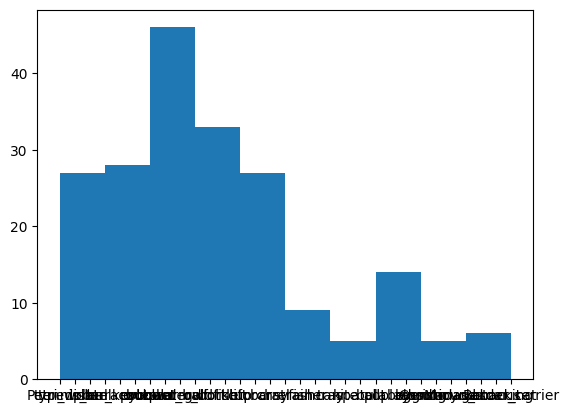

In [29]:
plt.hist(l)

In [33]:
import pandas as pd
from collections import Counter
from IPython.display import display, HTML
# Count the frequency of each class label
class_counts = Counter(l)

# Convert the Counter object to a DataFrame
df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count']).reset_index()
df = df.rename(columns={'index': 'Class Label'})

# Optional: Sort the DataFrame by count in descending order
df = df.sort_values(by='Count', ascending=False)

# Convert the DataFrame to an HTML table
html_table = df.to_html(index=False)

# Display the HTML table in the notebook
display(HTML(html_table))

Class Label,Count
croquet_ball,25
goldfish,25
plate,19
pole,17
bubble,15
torch,15
pot,11
barracouta,10
barrel,8
barrow,6


In [ ]:
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel
import torch
import numpy as np
import requests

neuron_idx=4

def get_neuron_trial_embeddings(neuron_index, all_cells, embedding, stim_table, num_trials=10, trial_length=900):
    """
    Compute the trial-wise embeddings for a given neuron.
    
    Args:
        neuron_index (int): Index of the neuron to analyze.
        all_cells (np.ndarray): Neural event data (num_cells x total_time_points).
        embedding (np.ndarray): Transformer embeddings (total_time_points x embedding_dim).
        stim_table (pd.DataFrame): Stimulus table containing 'start' times for trials.
        num_trials (int): Number of trials to process.
        trial_length (int): Number of time points per trial (default: 900).
        
    Returns:
        np.ndarray: A (num_trials x embedding_dim) array where each row corresponds to
                    the filtered embedding for a trial for the specified neuron.
    """
    embedding_dim = embedding.shape[1]
    trial_embeddings = np.zeros((num_trials, embedding_dim))
    
    # Verify that stim_table has enough trials
    if len(stim_table) < num_trials:
        print(f"Warning: Requested {num_trials} trials, but stim_table has only {len(stim_table)} trials.")
        num_trials = len(stim_table)
    
    print(f"Processing {num_trials} trials...")
    
    for trial_idx in range(10):
        try:
            # Access the start time of the trial using .iloc
            trial_start = stim_table.iloc[trial_idx*900:900*(trial_idx+1)]['start']
            trial_end = trial_start + trial_length  # Each trial has 900 time points
            #print(trial_start)

            # Extract the neural activity for this neuron during the trial
            neuron_activity = data_set_events[:,trial_start] # Shape: (900,)
            #print(f"Neuron activity shape: {neuron_activity.shape}")
            
            # Extract the corresponding embeddings for the trial
            trial_embedding = embedding  # Shape: (900, embedding_dim)
            #print(f"Trial embedding shape: {trial_embedding.shape}")

            v=neuron_activity[neuron_index].T
            X=trial_embedding

            filtered=v.T@X

            print(filtered.shape)
            # Assign the filtered embedding to the trial_embeddings array
            trial_embeddings[trial_idx, :] = filtered
        except IndexError as e:
            print(f"Error processing trial {trial_idx + 1}: {e}")
            trial_embeddings[trial_idx, :] = np.zeros(embedding_dim)
        except KeyError as e:
            print(f"KeyError accessing 'start' for trial {trial_idx + 1}: {e}")
            trial_embeddings[trial_idx, :] = np.zeros(embedding_dim)
    
    return trial_embeddings

# Example usage:
#neuron_index = 1  # Specify the neuron index (adjust as needed)
num_trials = 10   # Specify the number of trials to process
trial_length = 900  # Number of time points per trial

# Compute trial-wise embeddings for the specified neuron
filtered = get_neuron_trial_embeddings(
    neuron_index=neuron_index,
    all_cells=all_cells,
    embedding=embedding,
    stim_table=stim_table,
    num_trials=num_trials,
    trial_length=trial_length
)

print(f"Neuron {neuron_index} Trial Embeddings Shape: {neuron_trial_embeddings.shape}")


# Load the pretrained ViT model
model_name = 'google/vit-base-patch16-224'
vit_model = ViTModel.from_pretrained(model_name)  # Model without classification head
vit_classifier = ViTForImageClassification.from_pretrained(model_name)  # Includes classification head
vit_classifier.eval()  # Set to evaluation mode

# Move models to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit_model.to(device)
vit_classifier.to(device)

# Simulated `filtered` array (replace with actual `filtered` data)
# Ensure dimensions match CLS token size (e.g., 768 for ViT-base)
#filtered = np.random.rand(10, vit_model.config.hidden_size)  # Example data

# Convert `filtered` to a PyTorch tensor

def get_class_labels(filtered, vit_classifier):
    filtered_tensor = torch.tensor(filtered, dtype=torch.float32).to(device)

    # Pass `filtered` as the CLS token through the classification head
    with torch.no_grad():
        # Extract logits from the classification head using the filtered CLS tokens
        logits = vit_classifier.classifier(filtered_tensor)  # Directly classify the CLS tokens

    # Get the predicted class indices
    predicted_class_indices = torch.argmax(logits, dim=1).cpu().numpy()

    # Download ImageNet class index mapping
    response = requests.get("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json")
    imagenet_class_mapping = {int(k): v for k, v in response.json().items()}

    # Map class indices to human-readable labels
    predicted_class_labels = [imagenet_class_mapping[idx][1] for idx in predicted_class_indices]

    labels=[]
    # Print results
    for i, (cls_idx, cls_label) in enumerate(zip(predicted_class_indices, predicted_class_labels)):
        print(f"Row {i}: Predicted Class Index = {cls_idx}, Class Label = {cls_label}")
    labels.append(cls_label)
    return labels

def pipeline(neuron_index, all_cells, embedding, stim_table, num_trials=10, trial_length=900):
    # Compute trial-wise embeddings for the specified neuron
    filtered = get_neuron_trial_embeddings(
        neuron_index=neuron_index,
        all_cells=all_cells,
        embedding=embedding,
        stim_table=stim_table,
        num_trials=num_trials,
        trial_length=trial_length
    )

    # Get class labels for the filtered embeddings
    labels = get_class_labels(filtered, vit_classifier)
    return labels

labs=[]
for i in range(200):
    labels=pipeline(i, all_cells, embedding, stim_table, num_trials=10, trial_length=900)
    labs.append(labels)

print(labs)
    


Processing 10 trials...
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
Neuron 1 Trial Embeddings Shape: (10, 768)


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing 10 trials...
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
Row 0: Predicted Class Index = 852, Class Label = tennis_ball
Row 1: Predicted Class Index = 923, Class Label = plate
Row 2: Predicted Class Index = 733, Class Label = pole
Row 3: Predicted Class Index = 923, Class Label = plate
Row 4: Predicted Class Index = 522, Class Label = croquet_ball
Row 5: Predicted Class Index = 898, Class Label = water_bottle
Row 6: Predicted Class Index = 1, Class Label = goldfish
Row 7: Predicted Class Index = 738, Class Label = pot
Row 8: Predicted Class Index = 923, Class Label = plate
Row 9: Predicted Class Index = 712, Class Label = Petri_dish
Processing 10 trials...
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
Row 0: Predicted Class Index = 738, Class Label = pot
Row 1: Predicted Class Index = 522, Class Label = croquet_ball
Row 2: Predicted Class Index = 862, Class Label = torch
Row 3: Predicted Class Index = 389, Class Label = barrac